### 확률적 경사하강법(SGD)
- 기본 경사하강법(gradient descent): 전체 데이터를 사용하여 기울기를 계산함 &rarr; 시간이 많이 걸림
- 단점 보완 &rarr; 데이터의 일부만 사용

### 데이터셋(N)이 클 경우
- 문제점 1: 한 번에 처리가 안됨
  - N이 크지 않으면 GPU에서 한 번에 처리가 가능하지만, GPU의 메모리가 크지 않은데 N이 크면 일괄 처리가 어려움
  - 해결방안: GPU 메모리가 허용하는 범위 내에서 데이터를 나누어 처리
- 문제점 2: 학습 속도가 느림
  - 한 번의 파라미터 업데이트를 위해 전체 데이터를 feed-forward 시키는 것은 비효율적임
  - 해결방안: 확률적 경사하강법을 사용해 일부 데이터만 feed-forward 시켜서 파라미터를 업데이트함 

### 확률적 경사하강법
- 전체 데이터셋에서 랜덤 샘플링한 k개의 샘플만 feed-forward 시킴
  - 단, 샘플링에서 데이터가 중복해서 들어가지 않도록 반드시 비복원 추출을 수행해야 함
- 샘플링한 k개의 샘플 묶음을 미니배치라고 함
- 전체 데이터를 한 번씩 feed-forward 하는 것을 1 에폭(epoch)이라고 함
- 하나의 미니배치를 feed-forward 하는 것을 이터레이션이라고 함
- 1 에폭 동안 파라미터를 업데이트(이터레이션) 하는 횟수
  - N/k 번 업데이트
- 일반적인 미니배치의 크기: 256 or 512<br>
  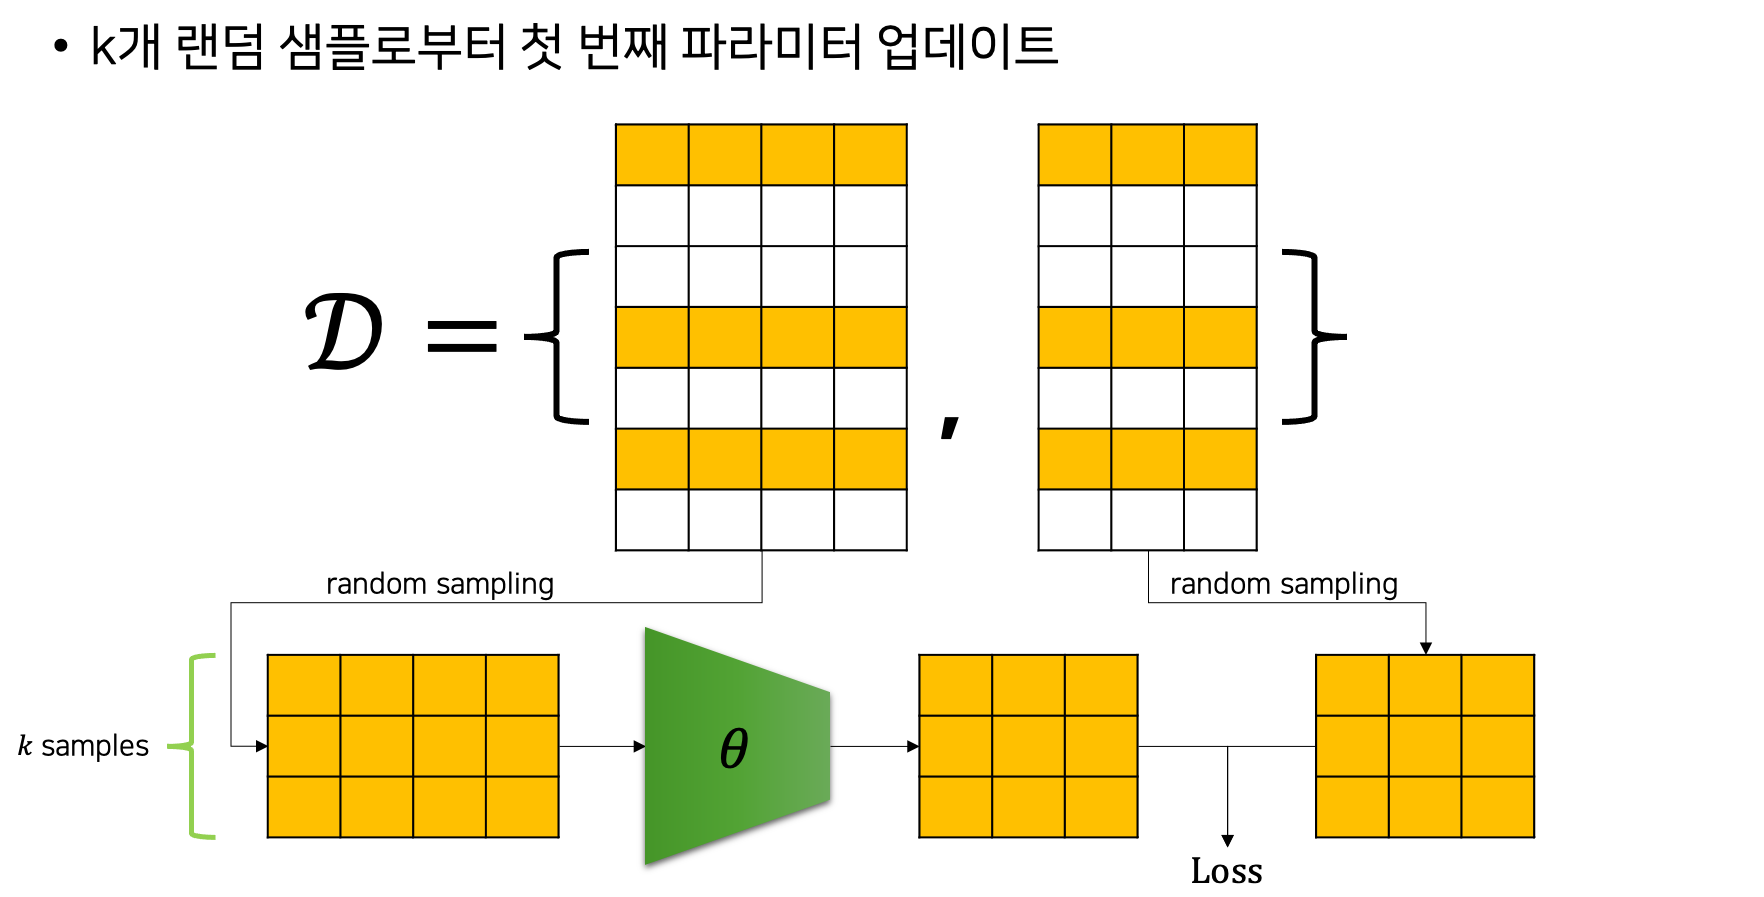<br>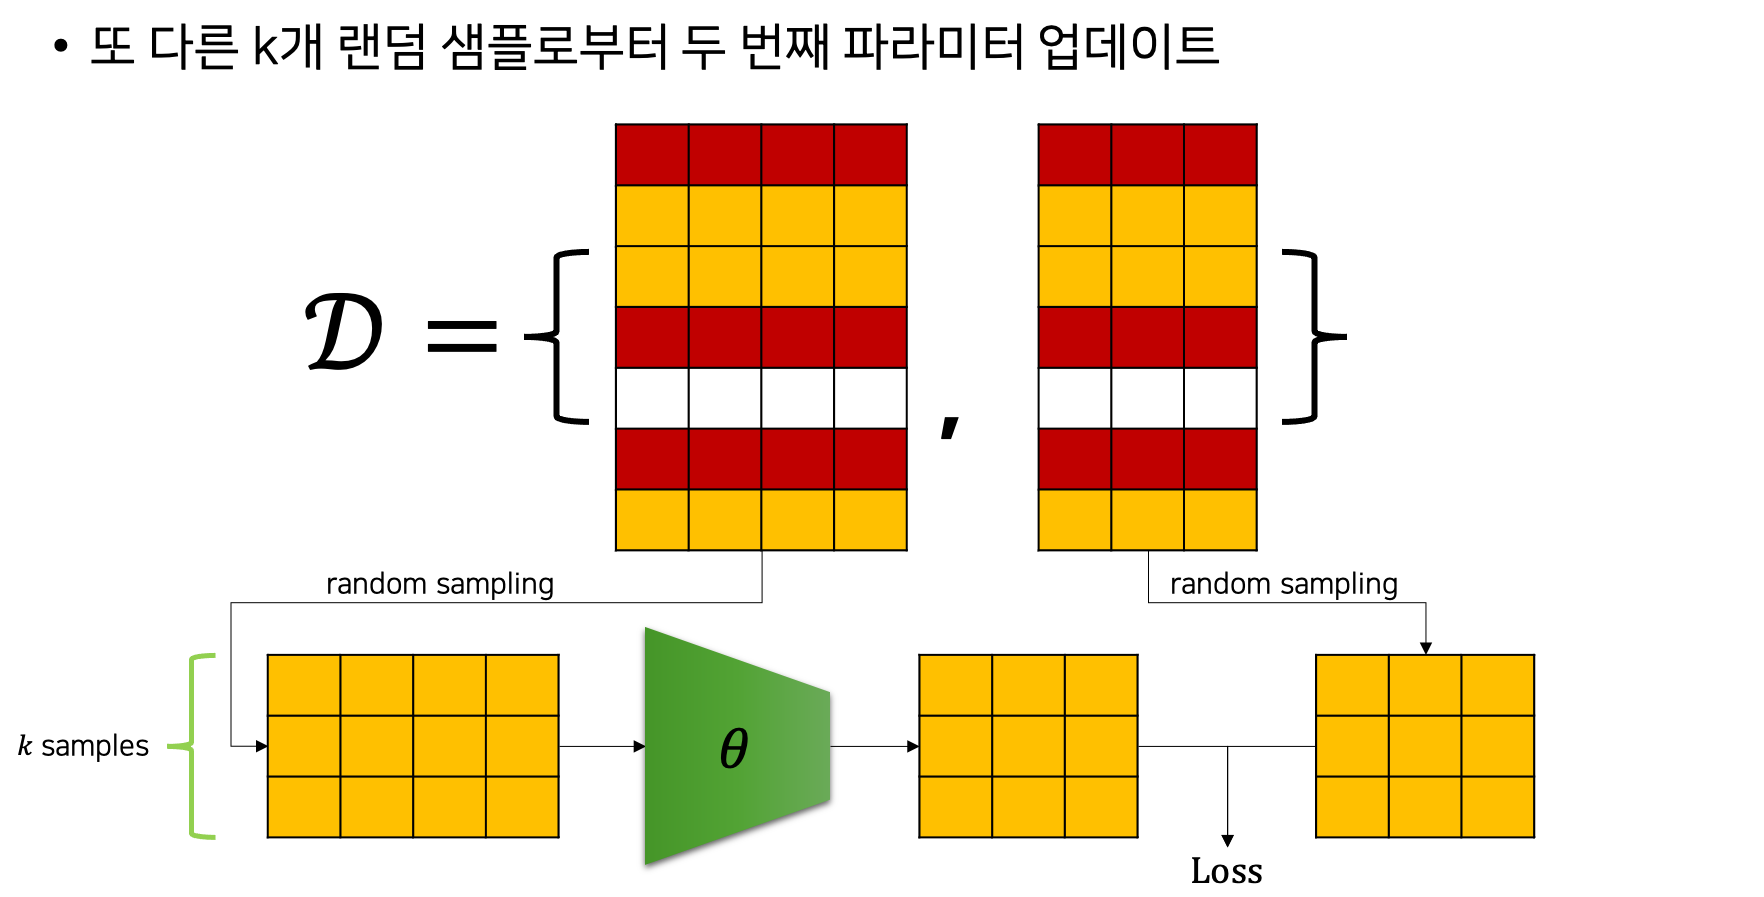

- 모든 데이터를 학습할 수는 없음 &rarr; 일부 데이터를 학습해 다른 데이터를 유추
- 컴퓨터도 수많은 양의 데이터를 한 번에 처리할 수는 없음(일부만 가능) <br>
  &rarr; 만약 1백만개를 학습할 수 있다 해도 1백만개를 한꺼번에 학습시키는 것은 비효율적<br>
  &rarr; 일부 데이터만 학습

- 전체 데이터에서 index값을 랜덤으로 돌린 후 split를 사용해 튜플을 만들고 이를 차례로 돌림

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

In [2]:
california = fetch_california_housing()
df=pd.DataFrame(california.data, columns=california.feature_names)
df['TARGET']=california.target
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847
20639,2.3886,16.0,5.254717,1.162264,1387.0,2.616981,39.37,-121.24,0.894


In [3]:
print(california.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

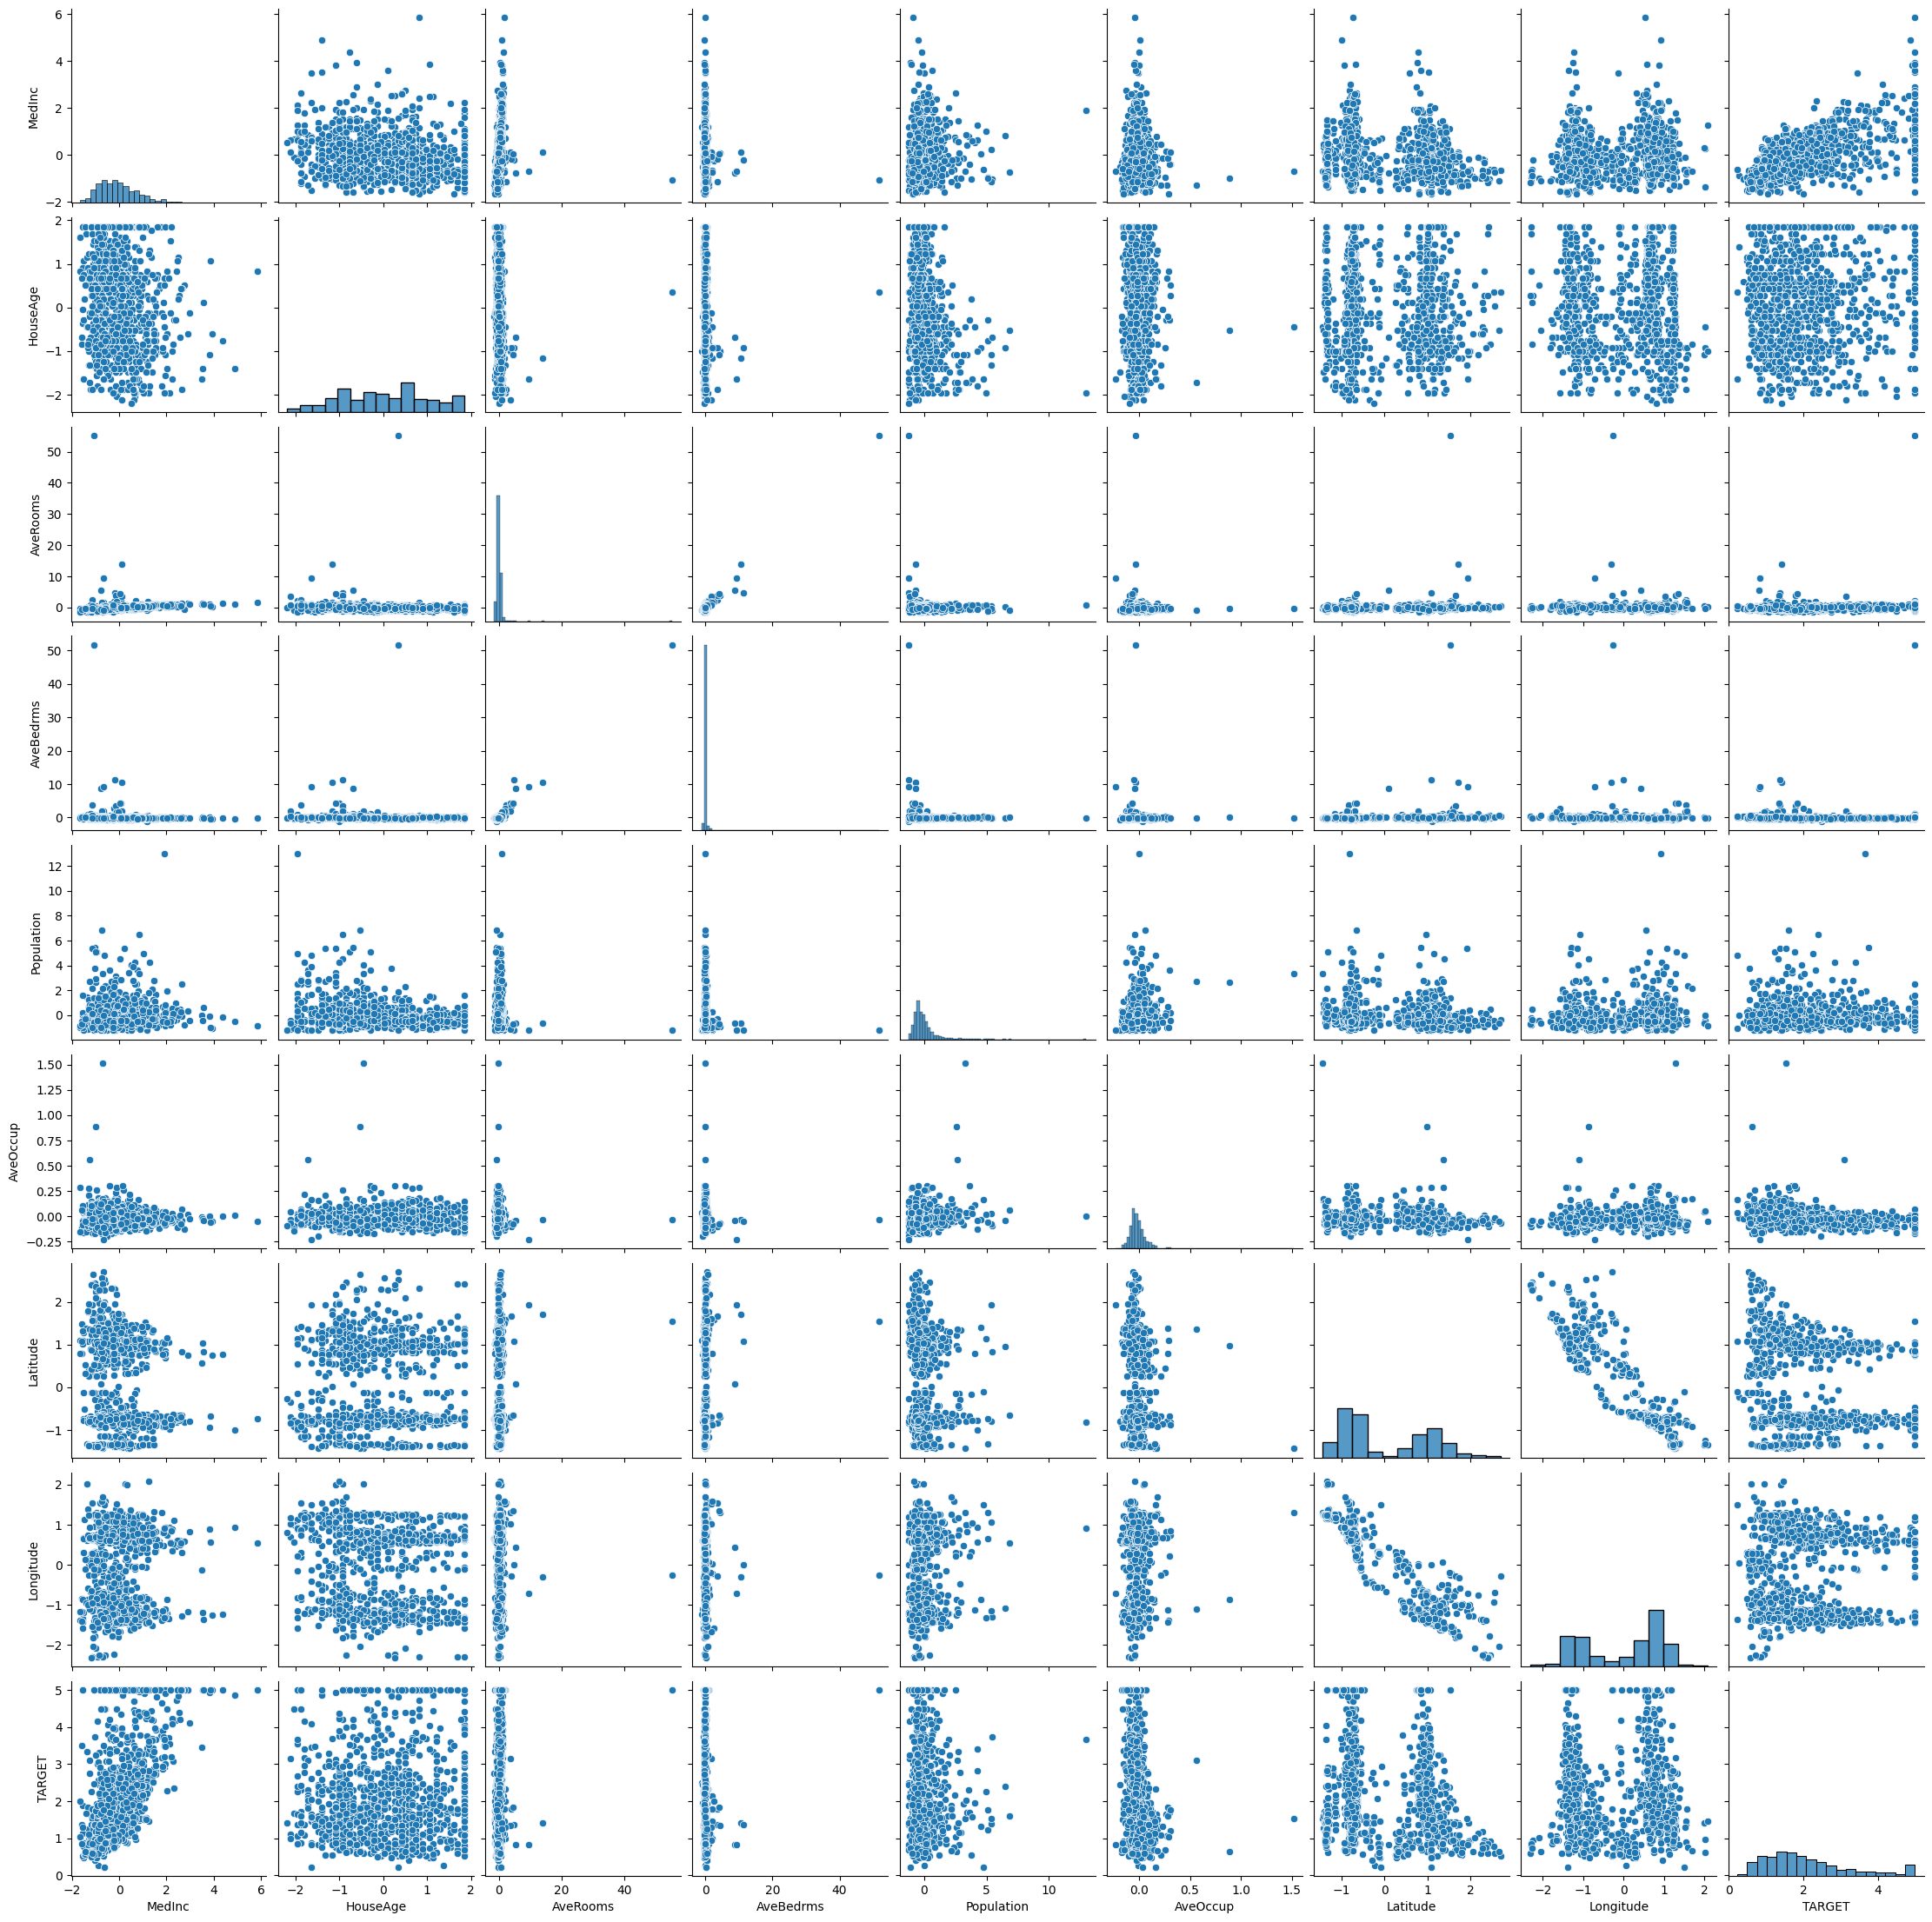

In [4]:
scaler=StandardScaler()
scaler.fit(df.values[:,:-1])
df.iloc[:,:-1] = scaler.transform(df.values[:,:-1]).round(4)
sns.pairplot(df.sample(1000))
plt.show()

In [5]:
df.tail()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,TARGET
20635,-1.2161,-0.2892,-0.1550,0.0774,-0.5126,-0.0491,1.8016,-0.7588,0.781
20636,-0.6916,-0.8454,0.2769,0.4624,-0.9444,0.0050,1.8063,-0.8187,0.771
20637,-1.1426,-0.9249,-0.0903,0.0494,-0.3695,-0.0717,1.7782,-0.8237,0.923
20638,-1.0546,-0.8454,-0.0402,0.1588,-0.6044,-0.0912,1.7782,-0.8736,0.847
20639,-0.7801,-1.0043,-0.0704,0.1384,-0.0340,-0.0437,1.7501,-0.8337,0.894


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
data=torch.from_numpy(df.values).float()
data.shape

torch.Size([20640, 9])

In [8]:
x=data[:, :-1]
y=data[:, -1:]

In [9]:
# 하이퍼 파라미터
n_epochs=1000
batch_size=256
learning_rate=1e-2
print_interval=100

In [10]:
model=nn.Sequential(
    nn.Linear(x.size(-1),6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3,y.size(-1)),
)
print(model)

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


- 히든 레이어가 가지는 의미: 요약 정보를 기억하는 장소
- 요약 -> 원래 들어간 데이터보다 더 작은 데이터

In [11]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
import time
start = time.time()

for i in range(n_epochs):
    indices = torch.randperm(x.size(0))
    x_=torch.index_select(x,dim=0, index=indices)
    y_=torch.index_select(y,dim=0, index=indices)
    x_=x_.split(batch_size, dim=0)
    y_=y_.split(batch_size, dim=0)
    y_hat=[] # 리스트
    total_loss=0

    for x_i, y_i in zip(x_, y_):
        y_hat_i=model(x_i)
        loss=F.mse_loss(y_hat_i, y_i)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        total_loss += float(loss) # 메모리 손실을 없애기 위함
        y_hat+=[y_hat_i] # 리스트 안에 원소로 들어감(값을 더하는 것이 아님)

    total_loss /= len(x_) # 1epoch 동안 미니배치의 손실 평균값

    if (i+1)%print_interval==0:
        print('Epoch %d/%d: loss=%.4e' % (i+1, n_epochs, total_loss))

y_hat=torch.cat(y_hat, dim=0)
y=torch.cat(y_, dim=0)
end=time.time()
elapsed=end-start
print('Elapsed time: %dm %ds'%(elapsed//60, int(elapsed-elapsed//60)))

C:\Users\legna\AppData\Local\Temp\ipykernel_1904\3062046234.py:21: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  total_loss += float(loss) # 메모리 손실을 없애기 위함


Epoch 100/1000: loss=3.5396e-01
Epoch 200/1000: loss=3.3659e-01
Epoch 300/1000: loss=3.3238e-01
Epoch 400/1000: loss=3.2944e-01
Epoch 500/1000: loss=3.1597e-01
Epoch 600/1000: loss=3.0943e-01
Epoch 700/1000: loss=3.0987e-01
Epoch 800/1000: loss=3.0818e-01
Epoch 900/1000: loss=3.0665e-01
Epoch 1000/1000: loss=3.0721e-01
Elapsed time: 1m 82s


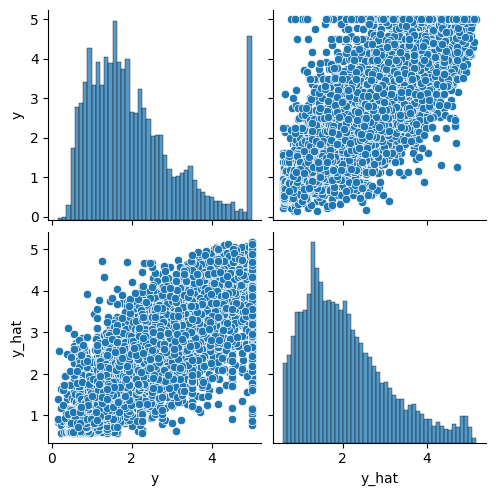

In [13]:
df=pd.DataFrame(torch.cat([y, y_hat], dim=1).detach_().numpy(),
                columns=["y","y_hat"])
sns.pairplot(df)
plt.show()

### 하이퍼파라미터(hyper-parameter)
- 모델의 성능에 영향을 끼치지만 자동으로 최적화되지 않는 파라미터
- 실험을 통해 사람이 튜닝해야 함
- 종류
  - 학습률
  - 미니배치 크기
  - 에폭의 수
  - 신경망의 깊이와 너비
  - 활성 함수의 종류: ReLU, LeakyReLU, sigmoid 등

### 적응형 학습률
- 기본: SGD
  - 처음 하이퍼 파라미터로 정한 학습률로 끝까지 학습시킴
- 모멘텀(momentum)
  - 시작부터 매번 계산된 그래디언트를 누적 &rarr; 관성의 개념 적용
  - 문제점: 처음 학습률의 크기가 최적화에 영향<br>
    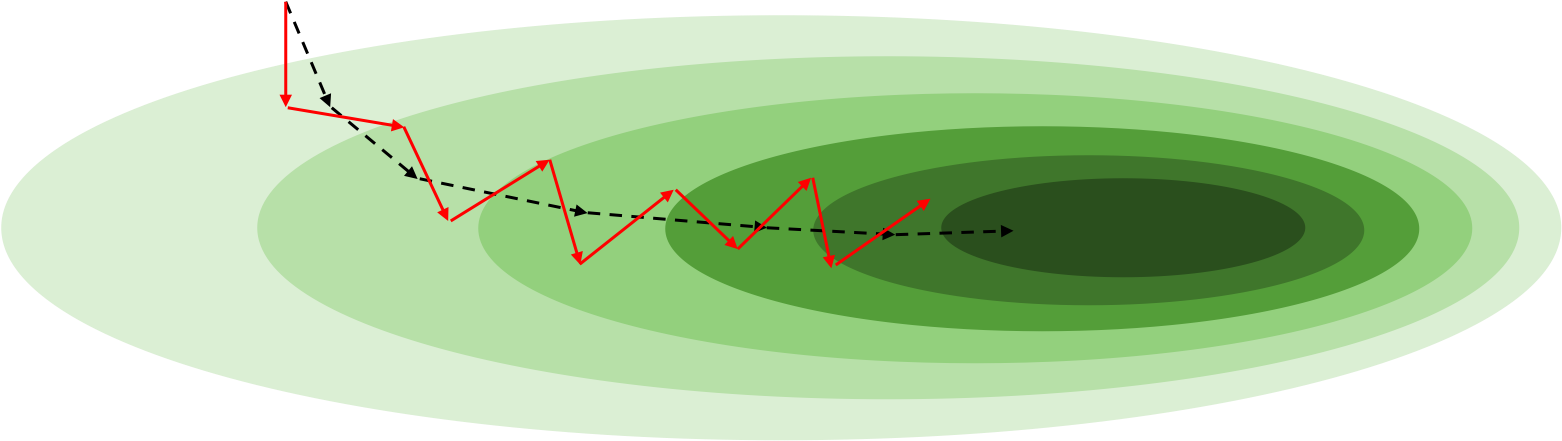
  - 적응형 학습률 &rarr; 자동으로 학습률 조정
    - 학습률 스케줄링
      - 초기에 큰 학습률 &rarr; 점차적으로 학습률을 감쇠시킴
      - 문제점: 감쇠를 위한 하이퍼파라미터가 필요함
    - 아다그래드
      - 가중치마다 다른 학습률 적용
      - 가중치 파라미터가 업데이트될수록 반비례하여 학습률이 작아짐
      - 문제점: 업데이트가 많이 된 후에는 학습률이 너무 작아져서 학습이 안됨
    - 아담
      - 적응형 + 모멘텀: 기존 방식의 단점들을 보완<br>
        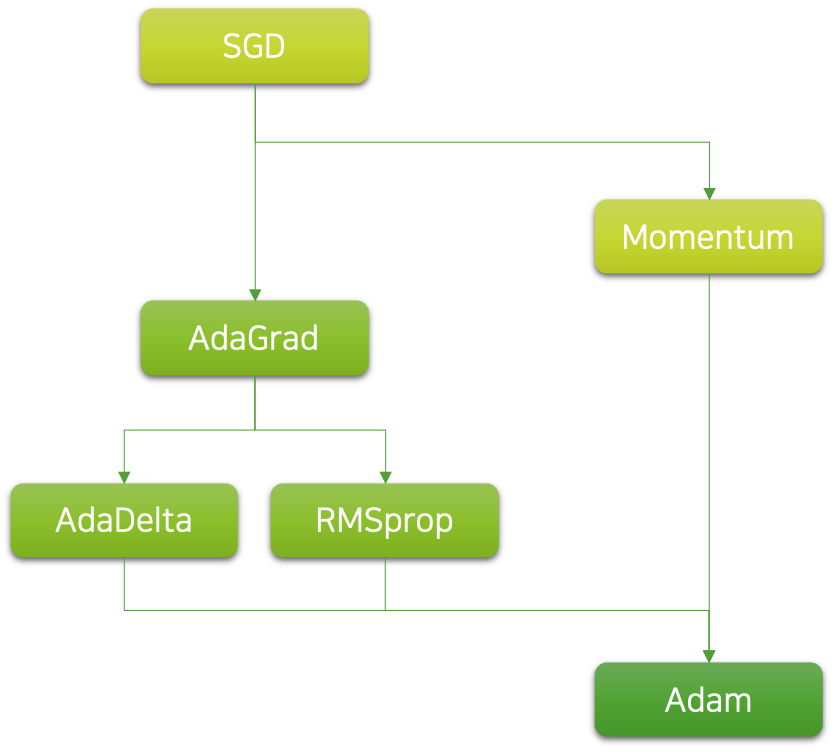

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_california_housing

california = fetch_california_housing()
df=pd.DataFrame(california.data, columns=california.feature_names)
df['TARGET']=california.target

scaler=StandardScaler()
scaler.fit(df.values[:,:-1])
df.iloc[:,:-1] = scaler.transform(df.values[:,:-1]).round(4)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

data=torch.from_numpy(df.values).float()
data.shape

x=data[:, :-1]
y=data[:, -1:]

n_epochs=4000
batch_size=256
#learning_rate=1e-2
print_interval=200

In [15]:
model=nn.Sequential(
    nn.Linear(x.size(-1),6),
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3,y.size(-1)),
)
print(model)

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


In [16]:
optimizer = optim.Adam(model.parameters())

In [18]:
start = time.time()
for i in range(n_epochs):
    indices = torch.randperm(x.size(0))
    x_=torch.index_select(x,dim=0, index=indices)
    y_=torch.index_select(y,dim=0, index=indices)
    x_=x_.split(batch_size, dim=0)
    y_=y_.split(batch_size, dim=0)
    y_hat=[] # 리스트
    total_loss=0

    for x_i, y_i in zip(x_, y_):
        y_hat_i=model(x_i)
        loss=F.mse_loss(y_hat_i, y_i)
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        total_loss += float(loss) # 메모리 손실을 없애기 위함
        y_hat+=[y_hat_i] # 리스트 안에 원소로 들어감(값을 더하는 것이 아님)

    total_loss /= len(x_) # 1epoch 동안 미니배치의 손실 평균값

    if (i+1)%print_interval==0:
        print('Epoch %d/%d: loss=%.4e' % (i+1, n_epochs, total_loss))

y_hat=torch.cat(y_hat, dim=0)
y=torch.cat(y_, dim=0)
end=time.time()
elapsed=end-start
print('Elapsed time: %dm %ds'%(elapsed//60, int(elapsed-elapsed//60)))

Epoch 200/4000: loss=2.7452e-01
Epoch 400/4000: loss=2.7324e-01
Epoch 600/4000: loss=2.7296e-01
Epoch 800/4000: loss=2.7263e-01
Epoch 1000/4000: loss=2.7267e-01
Epoch 1200/4000: loss=2.7231e-01
Epoch 1400/4000: loss=2.7135e-01
Epoch 1600/4000: loss=2.7018e-01
Epoch 2000/4000: loss=2.6926e-01
Epoch 2200/4000: loss=2.6906e-01
Epoch 2400/4000: loss=2.6978e-01
Epoch 2600/4000: loss=2.7011e-01
Epoch 2800/4000: loss=2.7049e-01
Epoch 3000/4000: loss=2.6949e-01
Epoch 3200/4000: loss=2.6899e-01
Epoch 3400/4000: loss=2.6796e-01
Epoch 3600/4000: loss=2.6844e-01
Epoch 3800/4000: loss=2.6805e-01
Epoch 4000/4000: loss=2.6845e-01
Elapsed time: 18m 1084s


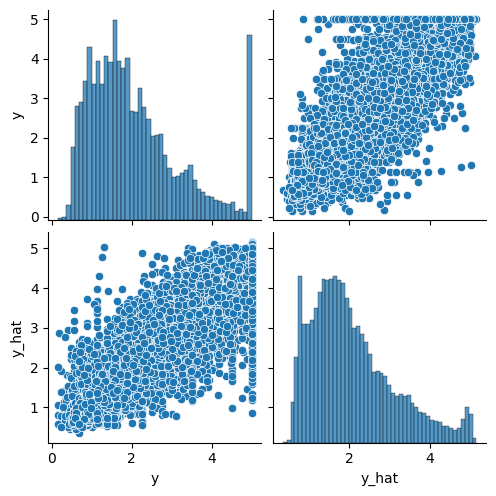

In [19]:
df=pd.DataFrame(torch.cat([y, y_hat], dim=1).detach_().numpy(),
                columns=["y","y_hat"])
sns.pairplot(df)
plt.show()

### 모델 평가하기
- 학습할 때의 손실평가 &rarr; 모델에 대한 평가가 아님
  - 학습용 데이터셋에 대한 손실값의 최소화 과정
- 오버피팅: 수집된 데이터에만 모델이 잘 동작하는 현상
  - 편향된, 혹은 노이즈가 있는 학습 데이터 &rarr; 낮은 손실값으로 확정
  - 서비스(테스트)용 데이터(학습하지 않은 데이터) &rarr; 손실이 커질 수 있음

- 손실함수를 통해 값을 평가(X)
- 우리가 만든 모델 자체에 대한 평가(O)

### 좋은 모델 평가
- 목표: 배포된 모델이 서비스 상에서 계속 잘 동작하도록 함 &rarr; 예상된 손실값 유지
- 테스트를 위한 데이터셋의 난이도 설정이 중요함
  - 너무 쉽지도 않고, 너무 희박하지도 않은 데이터셋 필요
  - 랜덤 샘플보다는 직접 엄선해서 구성하는 것이 좋음
    - 실질적으로는 학습 데이터 중 일부를 따로 떼어내어 테스트셋으로 설정하는 경우가 많음
- 정성 평가와 정량 평가의 결합
  - 정성형가: 정확, 고비용 &larr; 사람이 평가 (이미지 생성, 문장 생성 등 채점이 애매한 문제)
  - 정량 평가: 빠름, 저비용, 정확하지 않음 &larr; 컴퓨터에 의한 자동 채점
  - mirror version에서는 정량평가, major version에서는 정성 평가 진행

### 오버피팅
- 학습의 최종 목표: 일반화 오차를 최소화하는 것
  - 보지 못한 데이터에 대해 좋은 예측을 하는 것
- 학습 오차가 일반화 오차에 비해서 현격하게 낮아지는 현상
  - 학습 데이터의 편향이나 노이즈까지 학습한 경우

### 언더피팅
- 모델이 충분히 데이터를 학습하지 못해 학습 오차가 충분히 낮지 않은 현상
  - 모델의 표현력(수용능력: capacity) 부족으로 데이터의 복잡한 관계를 학습하지 못하는 경우
  - 학습량(epoch)이 부족하거나 최적화 과정에서 복잡한 손실 표현을 잘 헤쳐나가지 못하는 경우<br>
    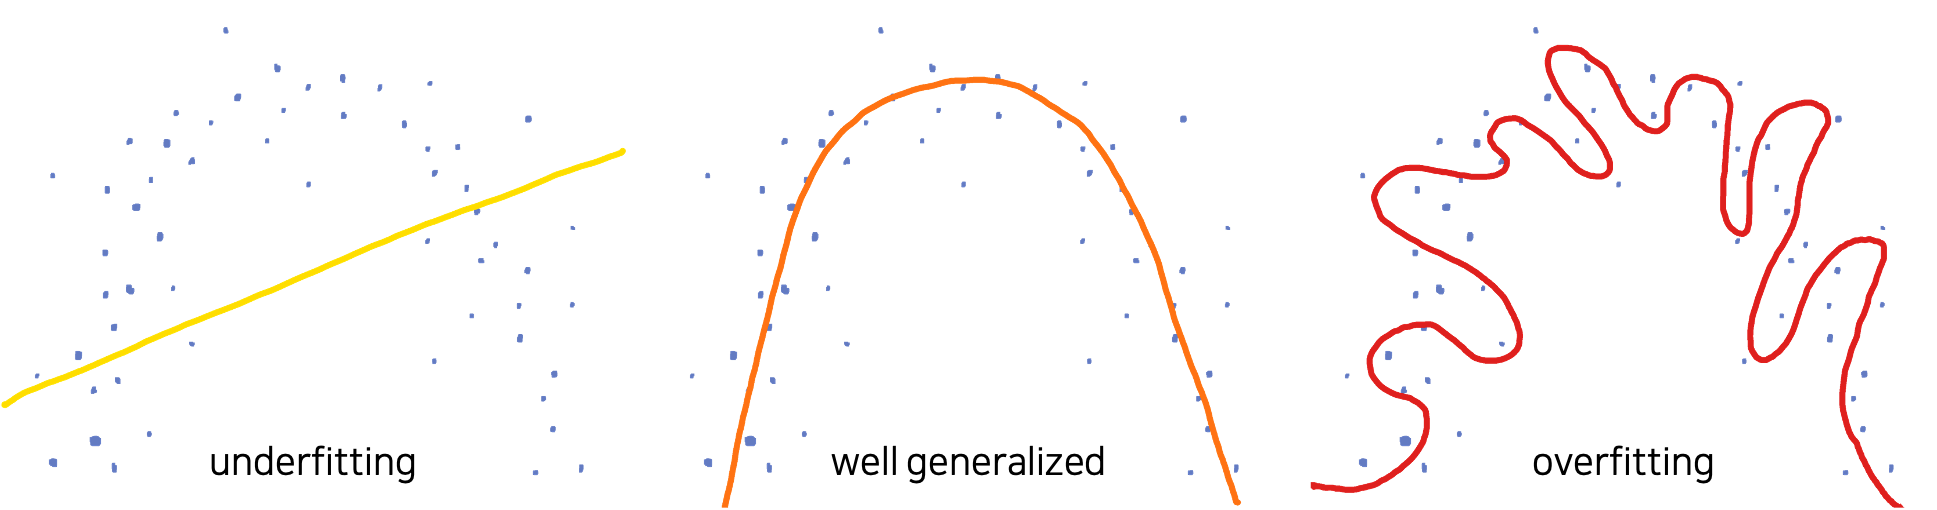

- 일반화 평가
- 학습을 안한 데이터의 일부는 학습, 일부는 테스트

### 검증 데이터 셋
- 학습 진행
  - 언더 피팅 &rarr; 최적 &rarr; 오버 피팅
  - 오버 비팅 직전에 학습을 멈추면 이론적으로 가장 이상적임
- 학습을 언제 끝낼 것인지를 어떻게 알 수 있을까? &rarr; 검증 데이터로 확인
  - 검증 데이터의 손실이 최소일 때 학습 종료
- 검증 데이터셋
  - 오버 피팅 발생을 검출하기 위해 학습  데이터의 일부를 임의로 지정
  - 단, 검증 과정에서는 최적화(학습: 역전파와 경사하강)를 진행하지 않음<br>
    &rarr; 순방향 계산(추론)만 수행<br>
    &rarr; 학습하지 않음
  - 데이터에 편향이 발생하지 않도록 랜덤 선택
- 학습 종료
  - 검증 손실값이 목표값에 도달했을 때
  - 검증 손실값이 더 이상 낮아지지 않을 때(일정 횟수의 epoch를 수행하는 동안 손실값 하강이 없을 때)
    - 가장 낮은 검증 손실값을 갖는 모델로 복원 &larr; 최소 손실값이 나올 때마다 best model을 저장해 둠

- 2개의 검증 데이터에 따라 결과값이 달라짐
- 검증 데이터가 학습에 관여를 하지 않는 것은 아님<br>
  &rarr; 만약 100개의 데이터가 있다면 60개를 뽑은 후 계속 돌려서 결과를 확인하고 남은 20개와 20개는 딱 1번만 돌려서 검증

### 모델 학습 과정 정리
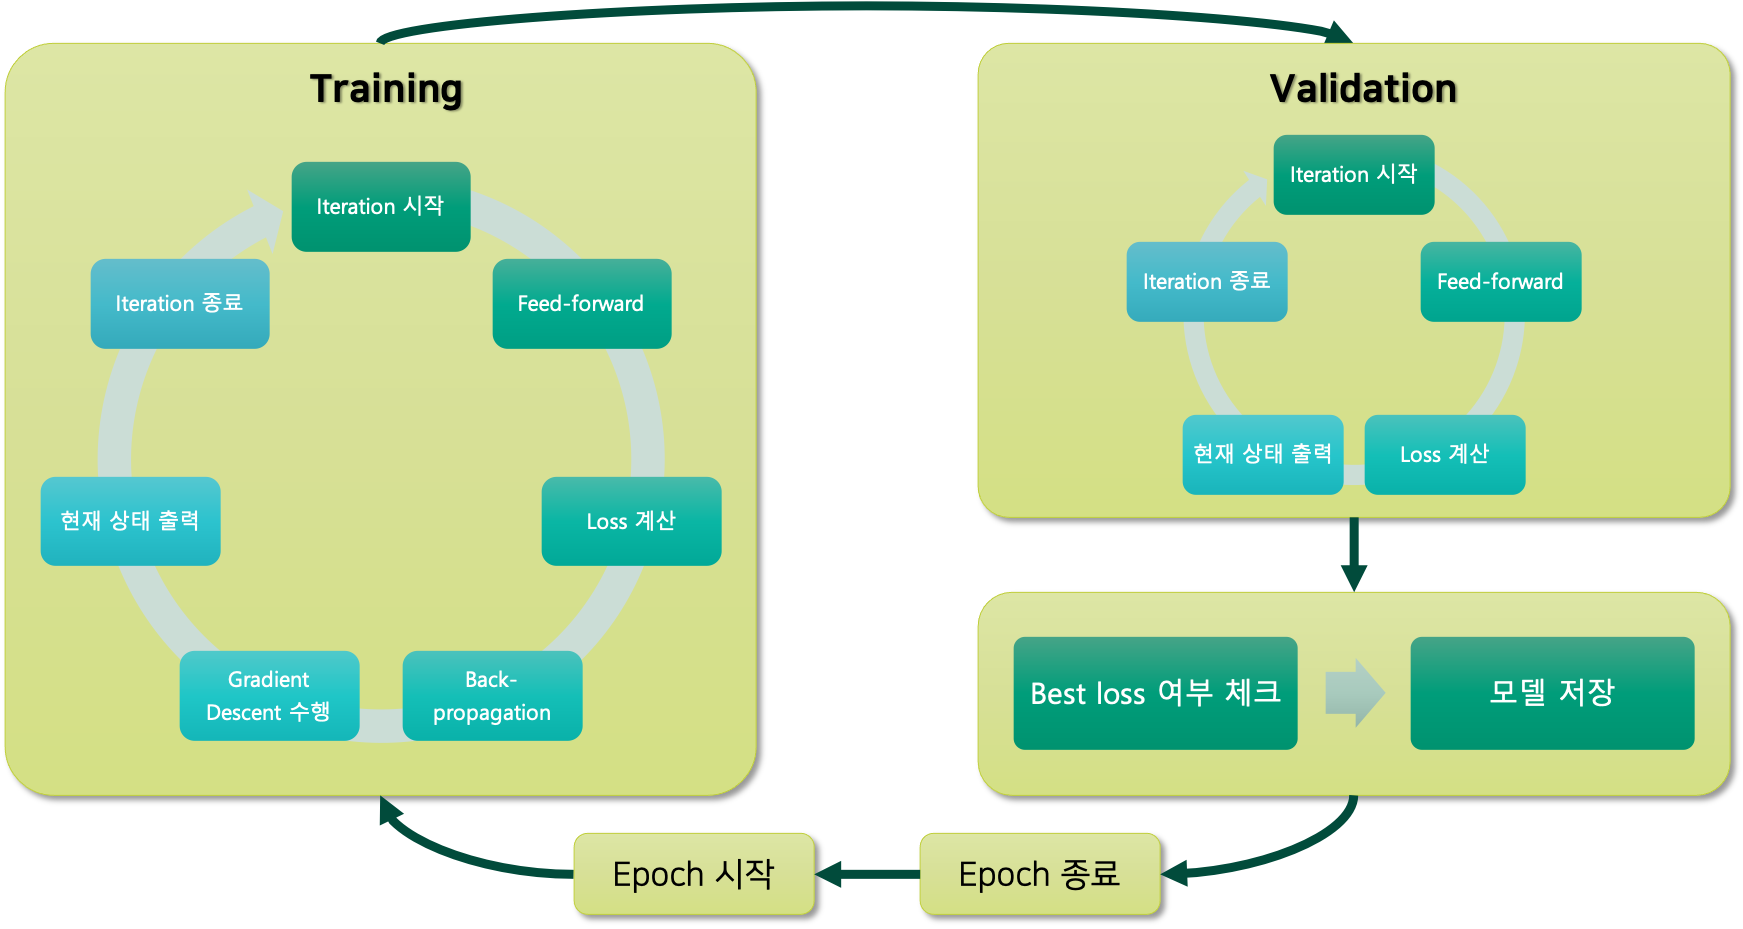

### 학습과 검증의 손실값 비교
- 모델의 수용능력이 충분하면 학습 손실(파란색)은 지속적으로 감소
- 학습과 검증이 손실값 차이가 에폭을 거듭할수록 떨어짐
- 검증 손실이 더 이상 감소하지 않으면 학습 종료
- 손실값은 들쑥날쑥하기 때문에, 학습 종료 후 가장 낮은 손실값을 갖는 모델을 복원하여 사용
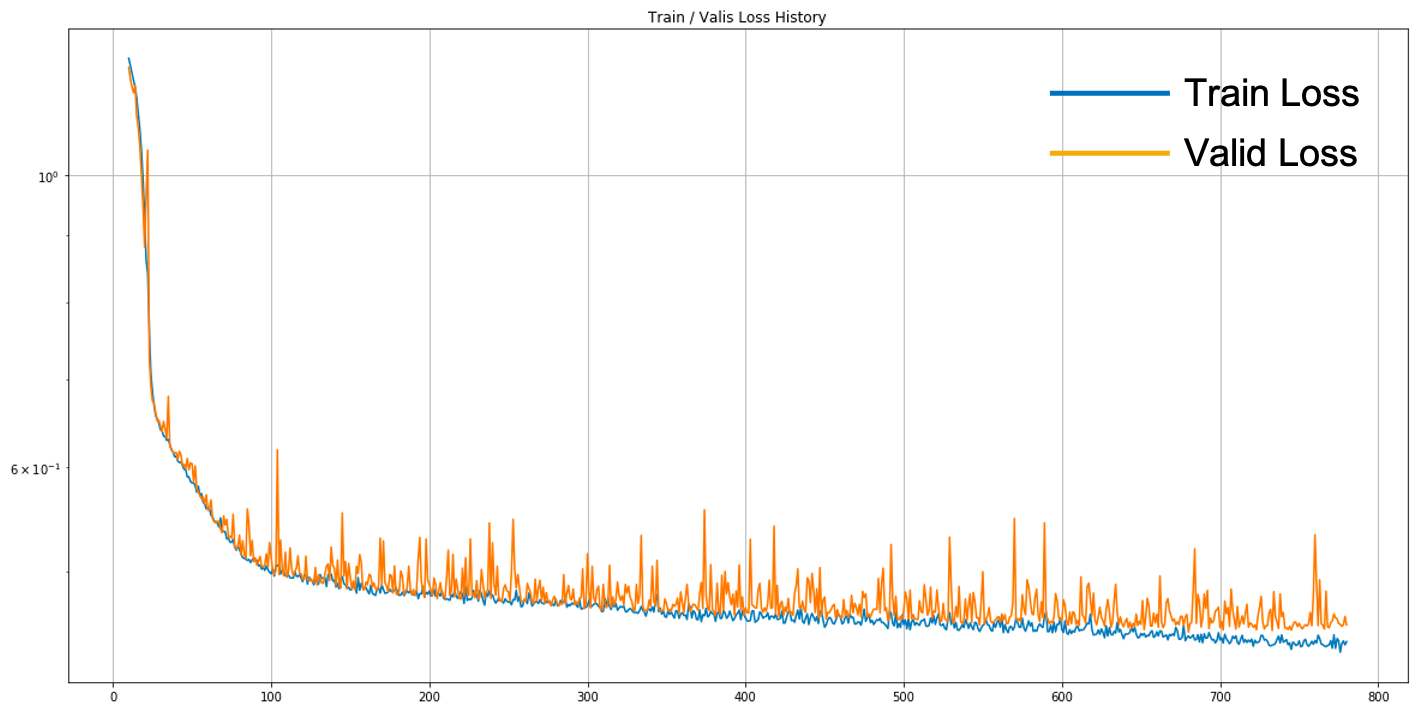

### 테스트셋의 필요성
- 평가를 위한 테스트셋으로 검증 데이터셋을 활용
  - 이미 검증 데이터셋에 모델이 오버피팅된 상태 &rarr; 좋은 성능
  - 비교하는 베이스라인 모델에 불공정한 평가

### (공정성을 위한) 데이터 나누기
- 학습에 사용되지 않는 데이터로 테스트셋 구성
- 데이터 나누기
  - 학습셋 + 검증셋+ 테스트셋<br>
    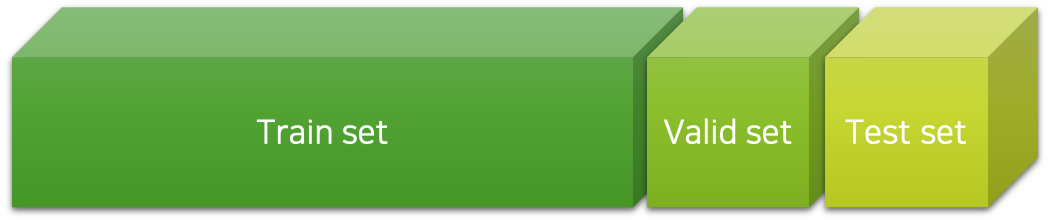

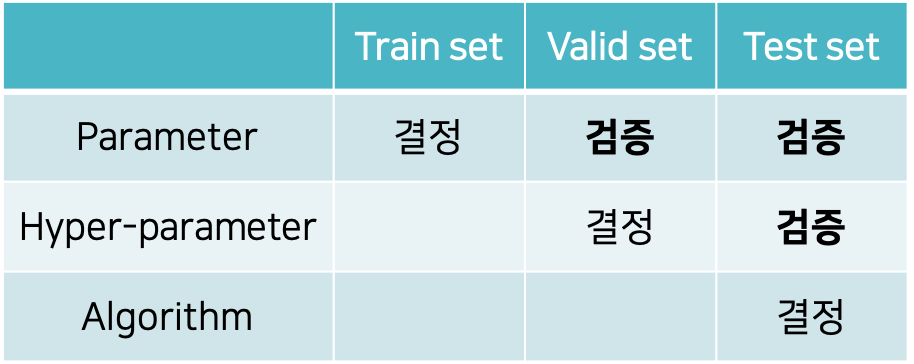